In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

import geomstats.backend as gs
from geomstats.geometry.discrete_curves import (
    DiscreteCurvesStartingAtOrigin,
    SRVMetric,
    insert_zeros,
)

from load_data import create_graph, read_and_normalize_property_data
from utils import random_graph_sequence, plot_function, remove_undirected_edges, resample_curve

INFO: Using numpy backend


In [2]:
stone_ids = ['BT.1.4-25.','BT.1.A.','BT.1.C.','BT.1.F.','BT.2.65.','BT.2.UUU.']
filename = 'Melton_sequence_data_sample.xlsx'

dataset = pd.read_excel(filename, sheet_name='SAMPLE_DATA')
data_collection = read_and_normalize_property_data(dataset, stone_ids)

graphs = {}
for stone_id in stone_ids:
    G = create_graph(dataset, data_collection, stone_id)
    graphs[stone_id] = G

/home/jp/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


In [9]:
node_id1 = 'BT.1.4-25.'
node_id2 = 'BT.1.A.'
k_sampling_points = 100

nodes_list1 = random_graph_sequence(graphs[node_id1])
nodes_list2 = random_graph_sequence(graphs[node_id2])

y1 = []
for node in nodes_list1:
    y1.append(graphs[node_id1].nodes[node]["surface"])
x1 = [i/(len(y1)-1) for i in range(len(y1))]
y2 = []
for node in nodes_list2:
    y2.append(graphs[node_id2].nodes[node]["surface"])
x2 = [i/(len(y2)-1) for i in range(len(y2))]

print(x1)
print(y1)

x1_resample, y1_resample = resample_curve(x1, y1, k_sampling_points=k_sampling_points)
x2_resample, y2_resample = resample_curve(x2, y2, k_sampling_points=k_sampling_points)

print(x1_resample)
print(y1_resample)

[0.0, 0.25, 0.5, 0.75, 1.0]
[-1.1744540461012496, -0.22886632197670045, -0.22886632197670045, -0.22886632197670045, 1.8610530120313542]
[0.0, 0.010101010101010102, 0.020202020202020204, 0.030303030303030304, 0.04040404040404041, 0.050505050505050504, 0.06060606060606061, 0.0707070707070707, 0.08080808080808081, 0.09090909090909091, 0.10101010101010101, 0.1111111111111111, 0.12121212121212122, 0.13131313131313133, 0.1414141414141414, 0.15151515151515152, 0.16161616161616163, 0.1717171717171717, 0.18181818181818182, 0.1919191919191919, 0.20202020202020202, 0.21212121212121213, 0.2222222222222222, 0.23232323232323232, 0.24242424242424243, 0.25252525252525254, 0.26262626262626265, 0.2727272727272727, 0.2828282828282828, 0.29292929292929293, 0.30303030303030304, 0.31313131313131315, 0.32323232323232326, 0.3333333333333333, 0.3434343434343434, 0.35353535353535354, 0.36363636363636365, 0.37373737373737376, 0.3838383838383838, 0.3939393939393939, 0.40404040404040403, 0.41414141414141414, 0.424

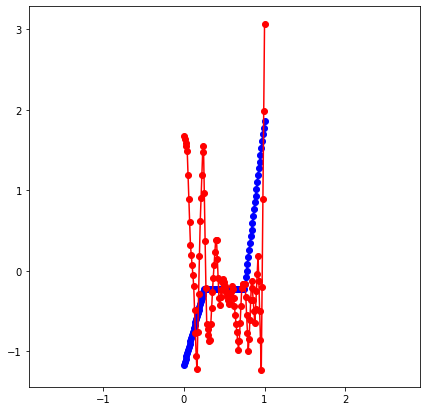

In [12]:
def plot_curve(curve, fmt="o-k", ax=None, add_origin=True):
    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 7))

    if add_origin:
        curve = insert_zeros(curve, axis=-2)
    ax.plot(curve[:, 0], curve[:, 1], fmt)

    return ax

curve_a = gs.vstack((x1_resample, y1_resample)).T
curve_b = gs.vstack((x2_resample, y2_resample)).T

ax = plot_curve(curve_a, "o-b", add_origin=False)
plot_curve(curve_b, "o-r", ax=ax, add_origin=False)
plt.axis("equal")
plt.show()

In [13]:
curves_r2 = DiscreteCurvesStartingAtOrigin(
    ambient_dim=2, k_sampling_points=k_sampling_points, equip=False
)

curve_a = curves_r2.projection(curve_a)
curve_b = curves_r2.projection(curve_b)

curve_a = curves_r2.normalize(curve_a)
curve_b = curves_r2.normalize(curve_b)

In [15]:
curves_r2.equip_with_metric(SRVMetric)
curves_r2.equip_with_group_action("rotations and reparametrizations")
curves_r2.equip_with_quotient_structure()

curve_b_aligned = curves_r2.fiber_bundle.align(curve_b, curve_a)

hgeod_fun = curves_r2.quotient.metric.geodesic(curve_a, curve_b)

print(hgeod_fun)

n_times = 20
times = gs.linspace(0.0, 1.0, n_times)
hgeod = hgeod_fun(times)

def plot_geodesic(geod, translation=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 7))

    geod = insert_zeros(geod, axis=-2)

    if translation is not None:
        geod = geod + gs.expand_dims(translation, axis=-2)

    ax.plot(geod[0, :, 0], geod[0, :, 1], "o-b")
    ax.plot(geod[-1, :, 0], geod[-1, :, 1], "o-r")

    for i in range(1, n_times - 1):
        ax.plot(geod[i, :, 0], geod[i, :, 1], "k")

    for j in range(k_sampling_points):
        ax.plot(geod[:, j, 0], geod[:, j, 1], "--k")

    return ax

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
plot_curve(curve_a, "o-b", ax=ax1)
plot_curve(curve_b_aligned, "o-r", ax=ax1)
ax1.set_title("Aligned curves")

plot_geodesic(hgeod, ax=ax2)
ax2.set_title("Horizontal geodesic")
plt.show()

/home/jp/anaconda3/lib/python3.9/site-packages/geomstats/geometry/discrete_curves.py:415: RuntimeWarning: divide by zero encountered in true_divide
  "...ij,...i->...ij", velocity, 1.0 / gs.sqrt(pointwise_velocity_norm)
/home/jp/anaconda3/lib/python3.9/site-packages/geomstats/geometry/discrete_curves.py:57: RuntimeWarning: invalid value encountered in subtract
  return (forward - center) / delta
/home/jp/anaconda3/lib/python3.9/site-packages/geomstats/geometry/discrete_curves.py:94: RuntimeWarning: invalid value encountered in subtract
  diff = (forward - backward) / (2 * delta)
/home/jp/anaconda3/lib/python3.9/site-packages/geomstats/geometry/discrete_curves.py:146: RuntimeWarning: invalid value encountered in subtract
  return (forward + backward - 2 * central) / (delta**2)
/home/jp/anaconda3/lib/python3.9/site-packages/geomstats/geometry/discrete_curves.py:103: RuntimeWarning: invalid value encountered in subtract
  diff_right = (array[slc_right] - array[slc_right_backward]) / delta

ValueError: `y` must contain only finite values.

In [3]:
####### Plot Graph #######
# plt.figure(figsize=(16,16))
# nx.draw(graphs['BT.1.A.'], pos=nx.kamada_kawai_layout(graphs['BT.1.A.']), with_labels=True, font_weight='bold')
# plt.show()

In [16]:
nodes_list = random_graph_sequence(graphs['BT.1.A.'])

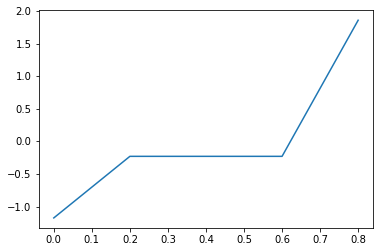

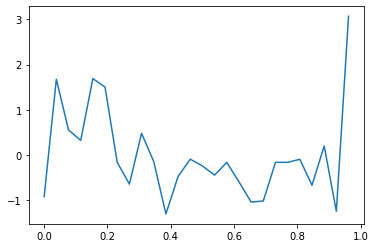

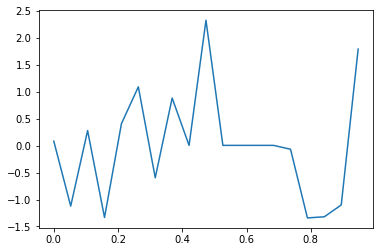

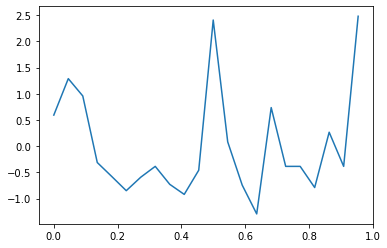

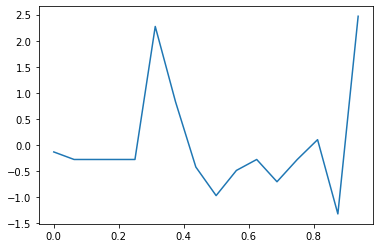

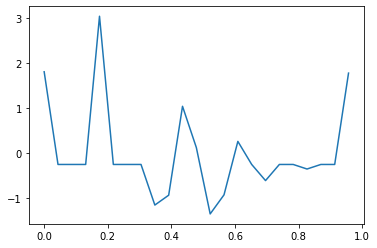

In [17]:
for id, g in graphs.items():
    nodes_list = random_graph_sequence(g)
    plot_function(nodes_list, graphs, id, "surface")
    plt.show()